In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import concurrent.futures
import multiprocessing

In [2]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print(e)

# Get the number of CPU cores for parallel processing
max_workers = multiprocessing.cpu_count()
print(f"Number of CPU cores: {max_workers}")

Num GPUs Available:  2
Number of CPU cores: 4


In [3]:
train_dir = '/kaggle/input/skin-cancer-img-augmented/skincancerimg/train'
test_dir = '/kaggle/input/skin-cancer-img-augmented/skincancerimg/test'
max_images_per_class = 2000

In [4]:
import os

# Function to print subfolder names and image count
def print_image_counts(directory):
    print(f"\nContents of: {directory}\n")
    for subfolder in sorted(os.listdir(directory)):  # Sort for consistency
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):  # Ensure it's a directory
            image_count = len(os.listdir(subfolder_path))  # Count images
            print(f"Class: {subfolder} - {image_count} images")

# Print for both train and test directories
print_image_counts(train_dir)
print_image_counts(test_dir)


Contents of: /kaggle/input/skin-cancer-img-augmented/skincancerimg/train

Class: actinic keratosis - 500 images
Class: basal cell carcinoma - 500 images
Class: dermatofibroma - 500 images
Class: melanoma - 500 images
Class: nevus - 500 images
Class: pigmented benign keratosis - 500 images
Class: seborrheic keratosis - 500 images
Class: squamous cell carcinoma - 500 images
Class: vascular lesion - 500 images

Contents of: /kaggle/input/skin-cancer-img-augmented/skincancerimg/test

Class: actinic keratosis - 120 images
Class: basal cell carcinoma - 120 images
Class: dermatofibroma - 120 images
Class: melanoma - 120 images
Class: nevus - 120 images
Class: pigmented benign keratosis - 120 images
Class: seborrheic keratosis - 120 images
Class: squamous cell carcinoma - 120 images
Class: vascular lesion - 120 images


In [5]:
# Function to create DataFrame from image directory
def create_dataframe(data_dir):
    data = [
        {"image_path": os.path.join(data_dir, dir_name, fname), "label": label}
        for label, dir_name in enumerate(os.listdir(data_dir))
        for fname in os.listdir(os.path.join(data_dir, dir_name))
    ]
    return pd.DataFrame(data)

# Function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((128, 128)))

# Function to plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [6]:
# Create combined dataframe
df = pd.concat([create_dataframe(train_dir), create_dataframe(test_dir)], ignore_index=True)

# Create label mapping
label_map = {i: label for i, label in enumerate(os.listdir(train_dir))}
num_classes = len(label_map)
print("Label mapping:", label_map)

# Limit each class to max_images_per_class samples
df = df.groupby("label").head(max_images_per_class).reset_index(drop=True)

# Parallelize image resizing
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    df['image'] = list(executor.map(resize_image_array, df['image_path']))

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Label mapping: {0: 'pigmented benign keratosis', 1: 'melanoma', 2: 'vascular lesion', 3: 'actinic keratosis', 4: 'squamous cell carcinoma', 5: 'basal cell carcinoma', 6: 'seborrheic keratosis', 7: 'dermatofibroma', 8: 'nevus'}


In [7]:
# Prepare data for training
X = df.drop(columns=['label','image_path'], axis=1)
y = df['label']

# Train-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

# Convert images to numpy arrays
X_train_val = np.asarray(X_train_val['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

# Normalize images
X_train_val_mean, X_train_val_std = X_train_val.mean(), X_train_val.std()
X_test_mean, X_test_std = X_test.mean(), X_test.std()

X_train_val = (X_train_val - X_train_val_mean) / X_train_val_std
X_test = (X_test - X_test_mean) / X_test_std

# One-hot encode labels
y_train_val = to_categorical(y_train_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Train-validation split
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=42)

# Reshape images
input_shape = (128, 128, 3)
X_train = X_train.reshape(-1, 128, 128, 3)
X_validate = X_validate.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.2855 - loss: 2.3197 - val_accuracy: 0.4490 - val_loss: 1.4807 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.6034 - loss: 1.1161 - val_accuracy: 0.5028 - val_loss: 1.5156 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.7650 - loss: 0.6910 - val_accuracy: 0.5532 - val_loss: 1.3421 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.8372 - loss: 0.4585 - val_accuracy: 0.6170 - val_loss: 1.3385 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.9106 - loss: 0.2718 - val_accuracy: 0.6170 - val_loss: 1.5038 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.9302 - loss: 0.2038 - val_accuracy: 0.5946 - val_loss: 1.6184 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━

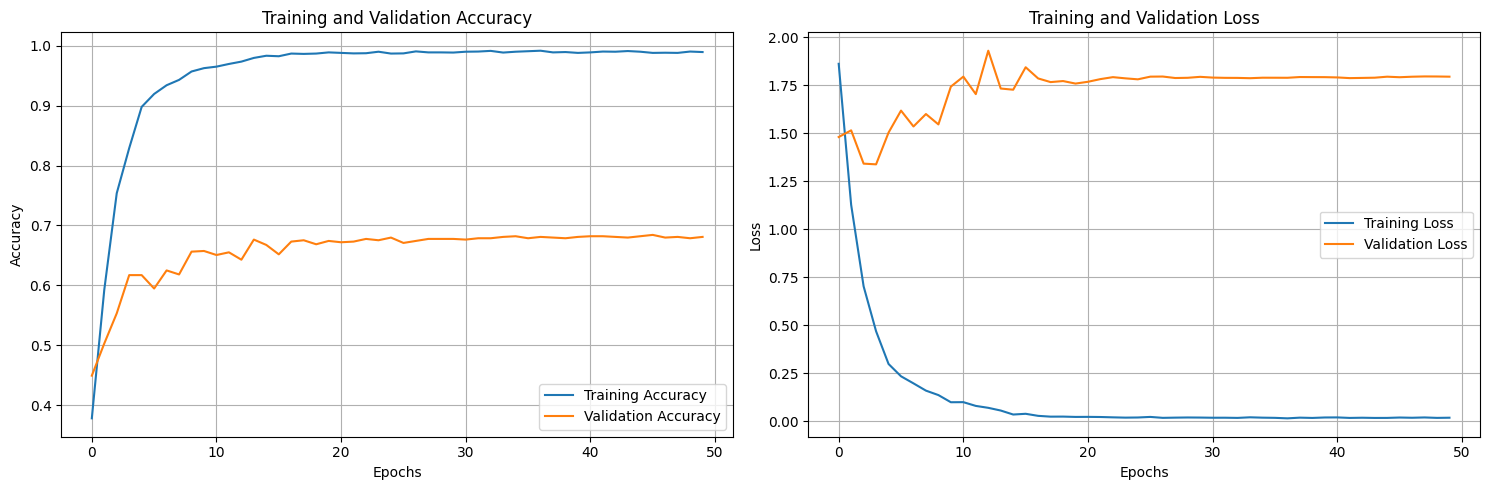

In [8]:
def create_and_train_model(X_train, y_train, X_validate, y_validate, input_shape, num_classes, epochs=25):
    input_tensor = Input(shape=input_shape)

    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)

    x = Flatten()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_validate, y_validate),
        callbacks=[learning_rate_reduction]
    )

    return model, history

# Train model
model, history = create_and_train_model(X_train, y_train, X_validate, y_validate, input_shape, num_classes, epochs=25)

# Plot training history
plot_training_history(history)

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.values())))

35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.7221 - loss: 1.3678

Test Accuracy: 0.6998
Test Loss: 1.4548
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 407ms/step

Classification Report:
                            precision    recall  f1-score   support

pigmented benign keratosis       0.72      0.75      0.74       121
                  melanoma       0.53      0.57      0.55       113
           vascular lesion       0.93      0.94      0.93       146
         actinic keratosis       0.60      0.61      0.60       117
   squamous cell carcinoma       0.69      0.68      0.68       130
      basal cell carcinoma       0.60      0.55      0.58       112
      seborrheic keratosis       0.60      0.61      0.60       120
            dermatofibroma       0.87      0.84      0.86       127
                     nevus       0.69      0.68      0.68       130

                  accuracy                           0.70      1116
                 macro avg       0.69      0.69      0.69      1116

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Accuracy: 0.6998
Precision: 0.7006
Recall: 0.6998
Classification Report:
                            precision    recall  f1-score   support

pigmented benign keratosis       0.72      0.75      0.74       121
                  melanoma       0.53      0.57      0.55       113
           vascular lesion       0.93      0.94      0.93       146
         actinic keratosis       0.60      0.61      0.60       117
   squamous cell carcinoma       0.69      0.68      0.68       130
      basal cell carcinoma       0.60      0.55      0.58       112
      seborrheic keratosis       0.60      0.61      0.60       120
            dermatofibroma       0.87      0.84      0.86       127
                     nevus       0.69      0.68      0.68       130

                  accuracy                           0.70      1116
                 macro avg       0.69      0.69      0.69      1116
              weighted avg       0.70      0.70      0.70      1116



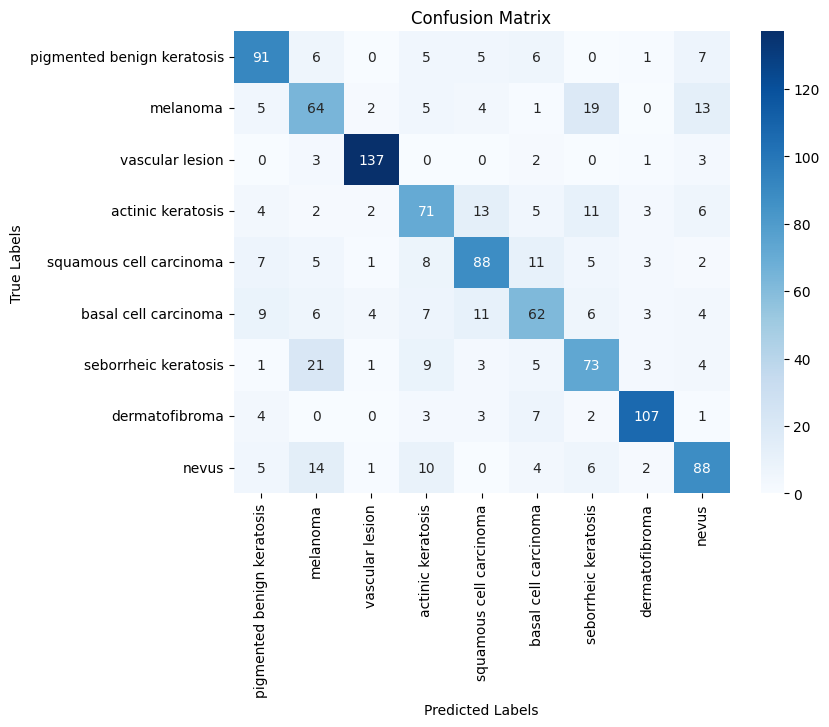

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoding to label indices
y_pred = np.argmax(model.predict(X_test), axis=1)  # Get predicted labels

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.values()))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function
plot_confusion_matrix(y_true, y_pred, list(label_map.values()))

In [11]:
# Save model
model.save('/kaggle/working/model.h5')
print("Model saved successfully!")

Model saved successfully!
